# Week 08: Classification

This notebook focuses on building a machine learning model to classify breast cancer tumors as malignant or benign using the Breast Cancer Wisconsin dataset. After a bit of preprocessing (including standard scaling, needed by logistic regression), we'll run three classification models on the dataset:
- Logistic Regression
- Decision Trees
- Random Forest

Finally, we'll look at our results with a variety of metrics and with confusion matrices.


In [1]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Modules
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA


# # Ignore warnings
# import warnings
# warnings.filterwarnings('ignore')

## Load and Explore the Dataset

We use the built-in Breast Cancer dataset from `sklearn.datasets`. It contains 30 numeric features that describe different properties of tumors. The target variable (`target`) is binary:
- `0`: Malignant (cancerous tumor)
- `1`: Benign (non-cancerous tumor)

In [2]:
# Load the dataset
cancer = load_breast_cancer()

# Convert to DataFrame
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

# Display the first few rows
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

### Dataset Info and Statistics

<Figure size 1600x1200 with 0 Axes>

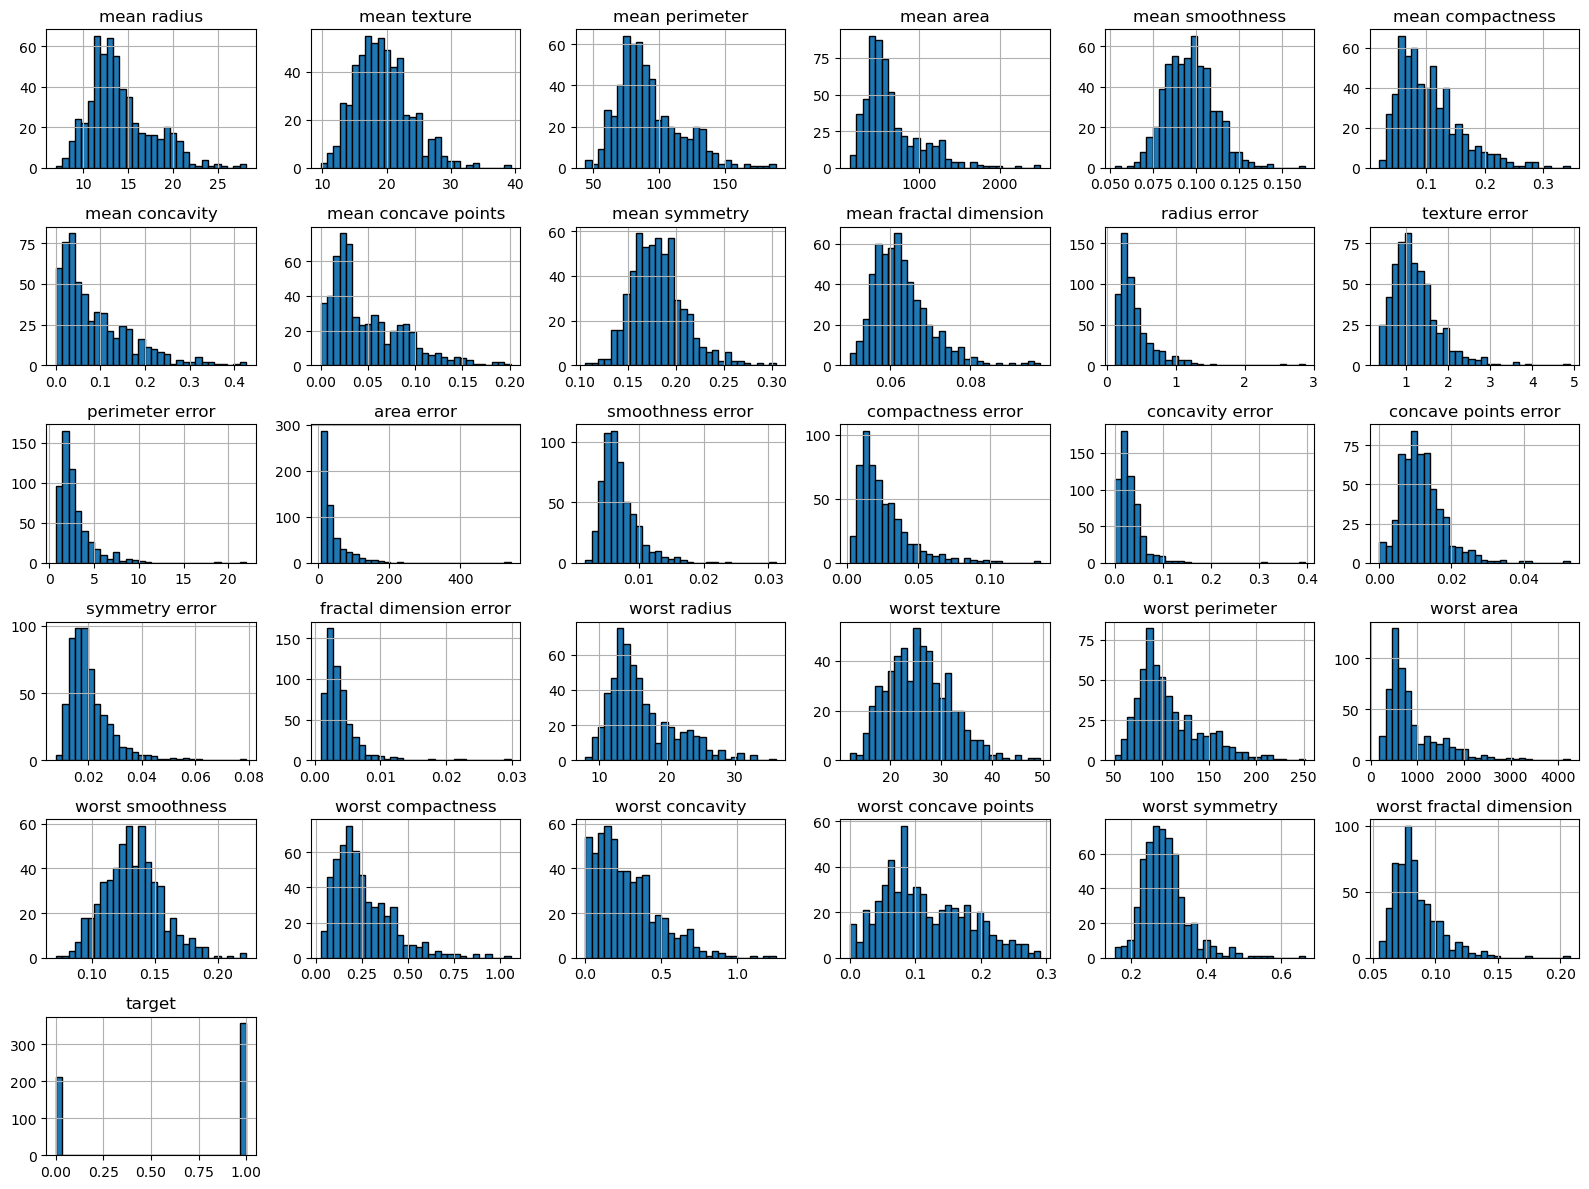

In [4]:

plt.figure(figsize=(16, 12)) 
df.hist(bins=30, figsize=(16, 12), layout=(6, 6), edgecolor='black')

# Improve spacing
plt.tight_layout()  # Prevent labels from overlapping
plt.show()


Let's look at the target using a bar chart....

target
1    357
0    212
Name: count, dtype: int64


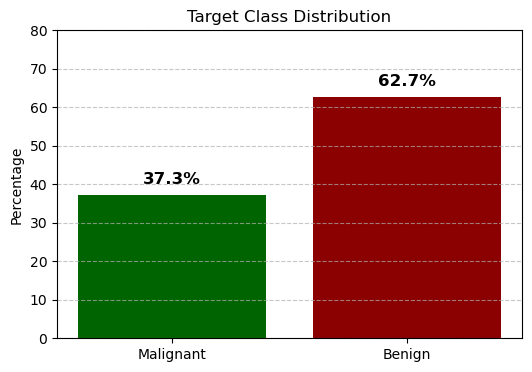

In [5]:
# Count occurrences of each class and convert to percentages

class_counts = df['target'].value_counts()
class_counts_percentage = df['target'].value_counts(normalize=True) * 100 

print(class_counts)

# Create bar chart
plt.figure(figsize=(6, 4))
plt.title('Target Class Distribution')

bars = plt.bar(class_counts_percentage.index, class_counts_percentage.values, color=['darkred', 'darkgreen'])

# Label each bar with its percentage (placed above bars)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 2,  # Move above the bar
             f'{bar.get_height():.1f}%',  # Format as percentage
             ha='center', va='bottom', color='black', fontsize=12, fontweight='bold')

# Labels and styling
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['Malignant', 'Benign'])
plt.ylim(0, 80)  # Set y-axis to 100% scale
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid

plt.show()



#### Split the data

In [6]:
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression


Logistic Regression Results:
K = 5
Cross-Validation Accuracy: 0.9736
Test Accuracy: 0.9737
              precision    recall  f1-score   support

           0     0.9762    0.9535    0.9647        43
           1     0.9722    0.9859    0.9790        71

    accuracy                         0.9737       114
   macro avg     0.9742    0.9697    0.9719       114
weighted avg     0.9737    0.9737    0.9736       114



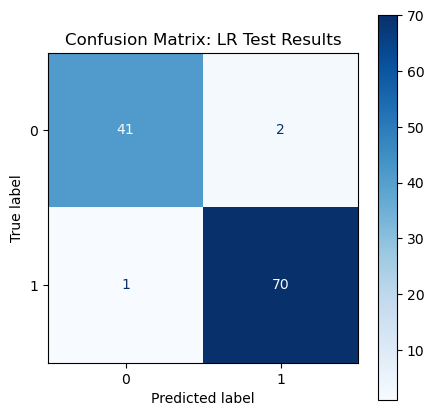

In [7]:
# Scale the features (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Logistic Regression model with default parameters
model_LR = LogisticRegression()

loo = LeaveOneOut()

K = 5
# Perform Cross-Validation
cv_scores = cross_val_score(model_LR, X_train_scaled, y_train, cv=K, scoring='accuracy')

# Fit model on the entire training set
model_LR.fit(X_train_scaled, y_train)

# Predictions
y_pred_log_reg = model_LR.predict(X_test_scaled)

# Print results
print("\nLogistic Regression Results:")
if K == loo:
    print("Leave_One Out CV")
else:
    print(f"K = {K}")
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(classification_report(y_test, y_pred_log_reg, digits=4))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(model_LR, X_test_scaled, y_test, cmap='Blues', ax=ax)
ax.set_title("Confusion Matrix: LR Test Results")
plt.show()


## Decision Tree


Decision Tree Results:
Best Parameters: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Cross-Validation Accuracy: 0.9473
Test Accuracy: 0.9561
              precision    recall  f1-score   support

           0     0.9750    0.9070    0.9398        43
           1     0.9459    0.9859    0.9655        71

    accuracy                         0.9561       114
   macro avg     0.9605    0.9464    0.9526       114
weighted avg     0.9569    0.9561    0.9558       114



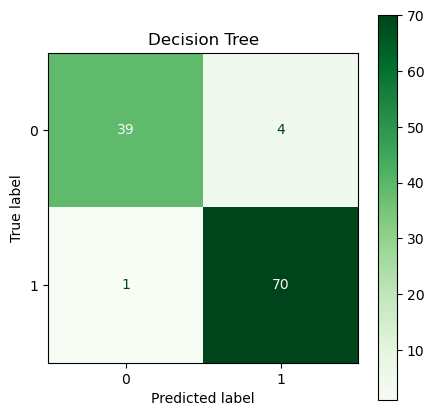

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Updated parameter grid with valid criteria for classifiers
param_grid_dt = {
    'criterion': ['gini','entropy'],  # use valid classifier criteria
    'max_depth': [4,5,6],
    'min_samples_split': [9,10,11],
    'min_samples_leaf': [1,2],
    'max_leaf_nodes': [9,10,11],
    'ccp_alpha': [0.1,0.05,0.01,0.005]
}

# Set n_jobs=-1 to use all available CPU cores
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,        # leverage all available cores
)

grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("\nDecision Tree Results:")
print(f"Best Parameters: {grid_dt.best_params_}\n")
print(f"Cross-Validation Accuracy: {grid_dt.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")

print(classification_report(y_test, y_pred_dt, digits=4))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test, cmap='Greens', ax=ax)
ax.set_title("Decision Tree")
plt.show()


## Random Forest


Random Forest Results:
Best Parameters: {'ccp_alpha': 0.005, 'max_depth': 5, 'max_leaf_nodes': 11, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 65}
Cross-Validation Accuracy: 0.9626
Test Accuracy: 0.9561
              precision    recall  f1-score   support

           0     0.9524    0.9302    0.9412        43
           1     0.9583    0.9718    0.9650        71

    accuracy                         0.9561       114
   macro avg     0.9554    0.9510    0.9531       114
weighted avg     0.9561    0.9561    0.9560       114



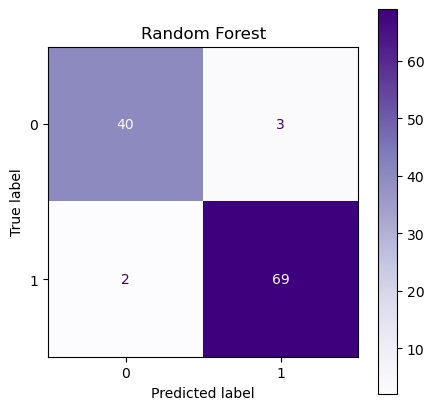

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Random Forest with GridSearchCV

# 'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}

param_grid_rf = {
    'n_estimators': list(range(60,71)),
    'max_depth': [4,5,6],
    'min_samples_split': [2,3],
    'min_samples_leaf': [1,2,3],
    'max_leaf_nodes': [10,11,12],
    'ccp_alpha': [0.01,0.005,0.001,0.0005]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Print results
print("\nRandom Forest Results:")
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Cross-Validation Accuracy: {grid_rf.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf,digits=4))

# Fix confusion matrix plotting
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Purples', ax=ax)
ax.set_title("Random Forest")
plt.show()


### Optional: Take a deep dive into why some samples were misclassified by Logistic Regression

1. Identify misclassified samples: Compare `y_test` with `y_pred_log_reg` and extract the indices where predictions were incorrect.
2. Inspect feature distributions: Check whether misclassified samples have extreme values or different distributions.
3. Visualize misclassified samples: Use scatterplots, boxplots, or PCA to examine patterns.
4. Check feature importance: Look at which features contribute most to the classification.

### Step 1: Collect the misclassified samples

In [10]:
import seaborn as sns
from sklearn.decomposition import PCA

# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred_log_reg)[0]
misclassified_samples = X_test_scaled[misclassified_indices]  # Get feature values
misclassified_labels = y_test.iloc[misclassified_indices]  # Get true labels
predicted_labels = y_pred_log_reg[misclassified_indices]  # Get predicted labels

# Convert to DataFrame for better analysis
misclassified_df = pd.DataFrame(misclassified_samples, columns=X_train.columns)
misclassified_df['True Label'] = misclassified_labels.values
misclassified_df['Predicted Label'] = predicted_labels

# Display first few misclassified samples
print("\nMisclassified Samples:")
print(misclassified_df.head())

# Save to CSV for further inspection if needed
misclassified_df.to_csv("misclassified_samples.csv", index=False)


Misclassified Samples:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -0.089933     -0.796710       -0.059775  -0.198215         0.356348   
1    -0.044631     -0.501027       -0.018614  -0.146600         0.996281   
2     0.028983      2.033403        0.027485  -0.085961        -0.971694   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          0.465167       -0.138676             0.063394      -0.542617   
1          0.463259        0.113275             0.109950       0.353327   
2          0.005355        0.269611            -0.110470      -1.708072   

   mean fractal dimension  ...  worst perimeter  worst area  worst smoothness  \
0                0.403127  ...         0.095893   -0.113900          0.414964   
1               -0.202279  ...         0.029902   -0.089917          0.853006   
2               -0.203667  ...        -0.138074   -0.199255         -1.016264   

   worst compactness  worst concavity  worst 

### Step 2: Just for Fun: PCA for Feature Patterns in Misclassified Samples
You can apply PCA to reduce dimensionality and visualize misclassified samples in a lower-dimensional space.
I'm not sure what this does for you, but I find it interesting!

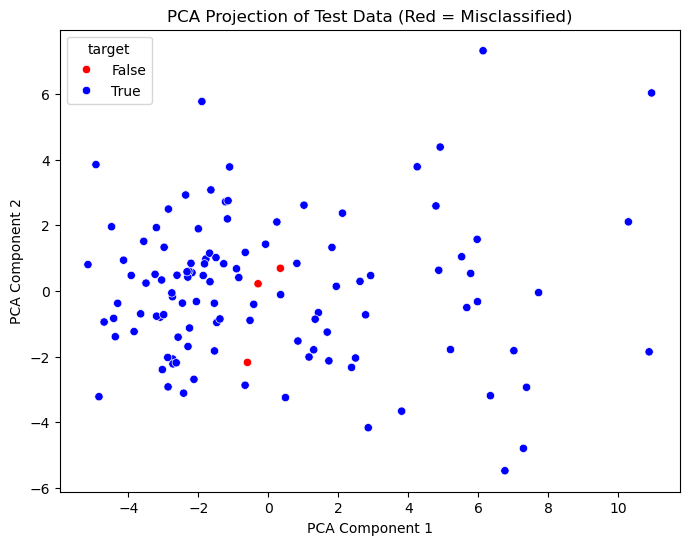

In [11]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=(y_test == y_pred_log_reg), palette={True: "blue", False: "red"})
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Test Data (Red = Misclassified)")
plt.show()

### Step 3: Check for Outliers in Features
Misclassified samples might have extreme feature values compared to correctly classified ones. A good way to check this is via boxplots.
Here are things to look for:

1. Wide Variance:  
   - Features with a broad interquartile range (IQR) indicate large variation in misclassified samples.  
   - *Example: ‘mean radius’ and ‘worst texture’.*  

2. Extreme Outliers:  
   - Features with many outliers (points outside whiskers) suggest rare or unusual values.  
   - *Example: ‘mean radius’, ‘worst symmetry’, and ‘compactness error’.*  

3. High Spread in Misclassified Samples:  
   - Large variance in misclassified data may indicate areas where the model struggles.  
   - *Example: ‘texture error’ and ‘worst area’.*  

4. Overlapping/Inconsistent Feature Values:  
   - Features with values significantly different from the majority can lead to poor generalization.  
   - *Example: ‘mean compactness’ and ‘worst fractal dimension’.*  

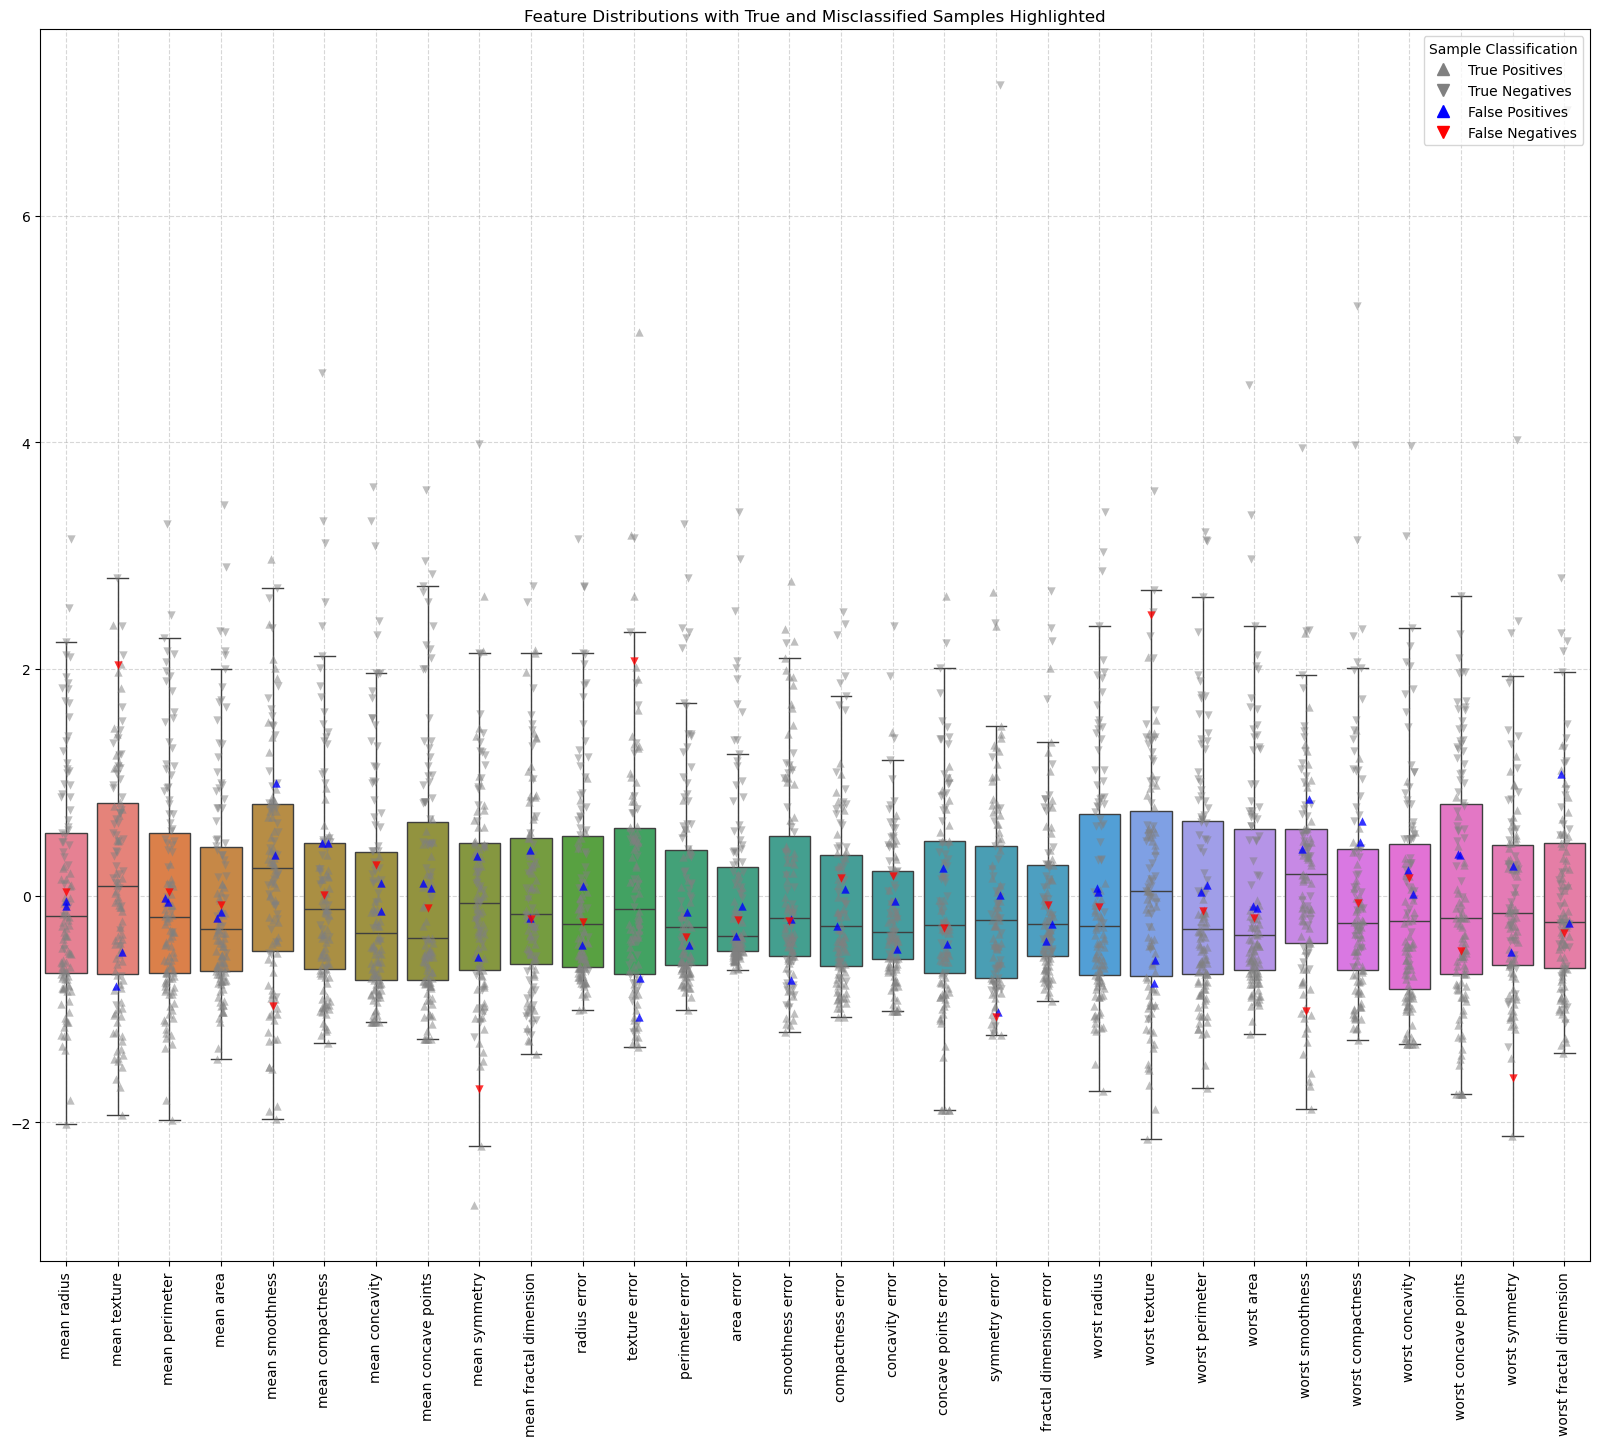

In [20]:

import matplotlib.lines as mlines

# Create DataFrame with scaled features
df_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Ensure y_test and y_pred_log_reg align properly before comparison
df_test['Misclassified'] = (y_test.reset_index(drop=True) != y_pred_log_reg)

# Identify different groups
false_positives = df_test[(df_test['Misclassified']) & (y_pred_log_reg == 1)]  # Predicted 1, actual 0
false_negatives = df_test[(df_test['Misclassified']) & (y_pred_log_reg == 0)]  # Predicted 0, actual 1
true_positives = df_test[~df_test['Misclassified'] & (y_pred_log_reg == 1)]  # Predicted 1, actual 1
true_negatives = df_test[~df_test['Misclassified'] & (y_pred_log_reg == 0)]  # Predicted 0, actual 0

# Drop classification labels from feature DataFrames
df_test = df_test.drop(columns=['Misclassified'])
false_positives = false_positives.drop(columns=['Misclassified'])
false_negatives = false_negatives.drop(columns=['Misclassified'])
true_positives = true_positives.drop(columns=['Misclassified'])
true_negatives = true_negatives.drop(columns=['Misclassified'])

# --- Plot combined boxplot and outliers ---
plt.figure(figsize=(20,16))

# Boxplot for all data (hides standard outliers)
sns.boxplot(data=df_test, showfliers=False)

# Overlay True Positives (gray circles)
sns.stripplot(data=true_positives, color="gray", alpha=0.5, jitter=True, size=6, marker='^')

# Overlay True Negatives (gray squares)
sns.stripplot(data=true_negatives, color="gray", alpha=0.5, jitter=True, size=6, marker='v')

# Overlay False Positives (blue circles)
sns.stripplot(data=false_positives, color="blue", alpha=0.8, jitter=True, size=6, marker='^')

# Overlay False Negatives (red diamonds)
sns.stripplot(data=false_negatives, color="red", alpha=0.8, jitter=True, size=6, marker='v')

# Manually create legend entries using Line2D
legend_handles = [
    mlines.Line2D([], [], color='gray', marker='^', linestyle='None', markersize=8, label="True Positives"),
    mlines.Line2D([], [], color='gray', marker='v', linestyle='None', markersize=8, label="True Negatives"),
    mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=8, label="False Positives"),
    mlines.Line2D([], [], color='red', marker='v', linestyle='None', markersize=8, label="False Negatives"),
]
plt.legend(handles=legend_handles, title="Sample Classification", loc="upper right")

plt.xticks(rotation=90)
plt.title("Feature Distributions with True and Misclassified Samples Highlighted")
plt.grid(linestyle='--', alpha=0.5)
plt.show()


### How to read box plots:

| Component | Meaning |
|-----------|---------|
| **Box (IQR)** | Middle 50% of data (Q1 to Q3) |
| **Line inside the box** | Median (Q2, 50th percentile) |
| **Whiskers** | Extend up to **1.5 × IQR** beyond Q1 & Q3 |
| **Outliers** | Points beyond whiskers (potential anomalies -- grey triangles)|


### Next Steps
- Try removing outliers and retraining.
- Consider feature selection to remove irrelevant features (next week's topic!)
- If you find strong non-linear patterns, a more flexible model like SVMs or decision trees may improve performance.
